# Challenge Data ENS : Return Forecasting of Cryptocurrency Clusters (par Napoleon X)

## Introduction

Ce projet s’inscrit dans le cadre du challenge **« Return Forecasting of Cryptocurrency Clusters »**, proposé sur **Challenge Data ENS** par **Napoleon X**, une société d’investissement quantitatif spécialisée dans les crypto-actifs.
L’objectif est de **prédire le rendement moyen d’un cluster de cryptomonnaies relativement au Bitcoin** durant la dernière heure d’une journée, à partir des rendements observés pendant les 23 premières heures.

---

## 1. Packages et paramètres

In [7]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import pickle
import missingno as msno

# modélisation
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

# paramètres de style pour les graphiques
plt.style.use("dark_background")

plt.rcParams.update({
    "grid.color": "#444444",
    "grid.alpha": 0.8,
    "grid.linestyle": "--", 
})

---

## 2. Data

Les clusters évoluent dans le temps et sont **mis à jour chaque semaine**. Chaque clustering est valide pour **trois semaines (21 jours)**, générant ainsi 21 échantillons par cluster.

Un **échantillon** correspond à un couple *{cluster, jour}* et contient les **rendements horaires des 23 premières heures** pour chacun des actifs du cluster, exprimés **relativement au Bitcoin**. 

Deux variables additionnelles, **md** et **bc**, sont fournies mais leur nature reste confidentielle.

Les actifs et clusters sont **anonymisés**, et les prix exprimés en Bitcoin :

* **rendement positif** → surperformance par rapport à Bitcoin
* **rendement négatif** → sous-performance.

### 2.1 Importation des données

In [8]:
x_train = pd.read_csv('input/input_train__fppJZ22.csv')
y_train = pd.read_csv('input/y_train_CGZ7jXu.csv')
x_test = pd.read_csv('input/input_test__2scdXsn.csv')

with open("input/adjacency_matrices_pgWTvf5.pkl", "rb") as file:
    adj = pickle.load(file)
    
print("Taille de x_train :", x_train.shape)
print("Taille de y_train :", y_train.shape)

display(x_train.head(), y_train.head())

Taille de x_train : (491038, 29)
Taille de y_train : (30494, 2)


,id,cluster,day,asset,md,bc,ret_1,ret_2,ret_3,ret_4,...,ret_14,ret_15,ret_16,ret_17,ret_18,ret_19,ret_20,ret_21,ret_22,ret_23
0,0,0,17,10,-5.734573,0.125855,-0.002060,0.005848,-0.002736,-0.005487,...,NaN,-0.000339,0.001018,-0.002372,-0.000340,-0.000680,-0.007140,0.006849,0.002041,-0.001697
1,1,0,0,13,-5.813696,0.418711,-0.042280,-0.009460,-0.005173,-0.006000,...,0.004107,-0.005726,0.006993,-0.003268,0.015574,-0.010492,0.004486,0.011368,0.001606,0.000401
2,2,0,20,12,-5.814399,0.500111,0.003665,-0.010841,0.007557,0.004981,...,-0.000113,-0.000170,-0.002833,-0.007442,-0.001832,-0.005677,-0.007093,0.001626,0.004349,-0.004677
3,3,0,19,12,-5.814399,0.500111,-0.018364,0.003789,0.011795,0.016029,...,0.005604,-0.009794,-0.001023,-0.002959,0.002568,-0.005579,0.001317,-0.010005,0.004677,-0.004196
4,4,0,18,12,-5.814399,0.500111,-0.001589,0.011711,-0.010507,-0.002555,...,0.002530,-0.018505,-0.010855,0.002022,0.001211,-0.002648,0.001559,-0.001153,0.000635,0.001961


,sample_id,target
0,0,0.000301
1,1,-0.011966
2,2,-0.011395
3,3,0.000664
4,4,0.002852


### 2.2 Structure des données

Les **données d’entrée (`x_train`)** comprennent 29 colonnes :

* **id**, **cluster**, **day**, **asset**, **md**, **bc**
* **ret_1 à ret_23** : rendements horaires relatifs au Bitcoin sur les 23 premières heures de la journée.

Les **données de sortie (`y_train`)** contiennent :

* **sample_id** : identifiant unique d’un échantillon *{cluster, jour}*
* **target** : rendement moyen du cluster relativement au Bitcoin pendant la 24ᵉ heure.

L’identifiant sample_id est calculé avec :

> `sample_id` = `cluster` × 21 + `day`

Le jeu de données inclut **2 077 clusters**, soit environ **43 627 échantillons théoriques**. Après nettoyage, on obtient environ **30 494 échantillons d’entraînement (≈70 %)** et **13 133 échantillons de test (≈30 %)**, les échantillons de test correspondant à des **périodes ultérieures** pour assurer une séparation temporelle réaliste.

### 2.3 Valeurs manquantes

#### 2.3.1 Analyse des valeurs manquantes

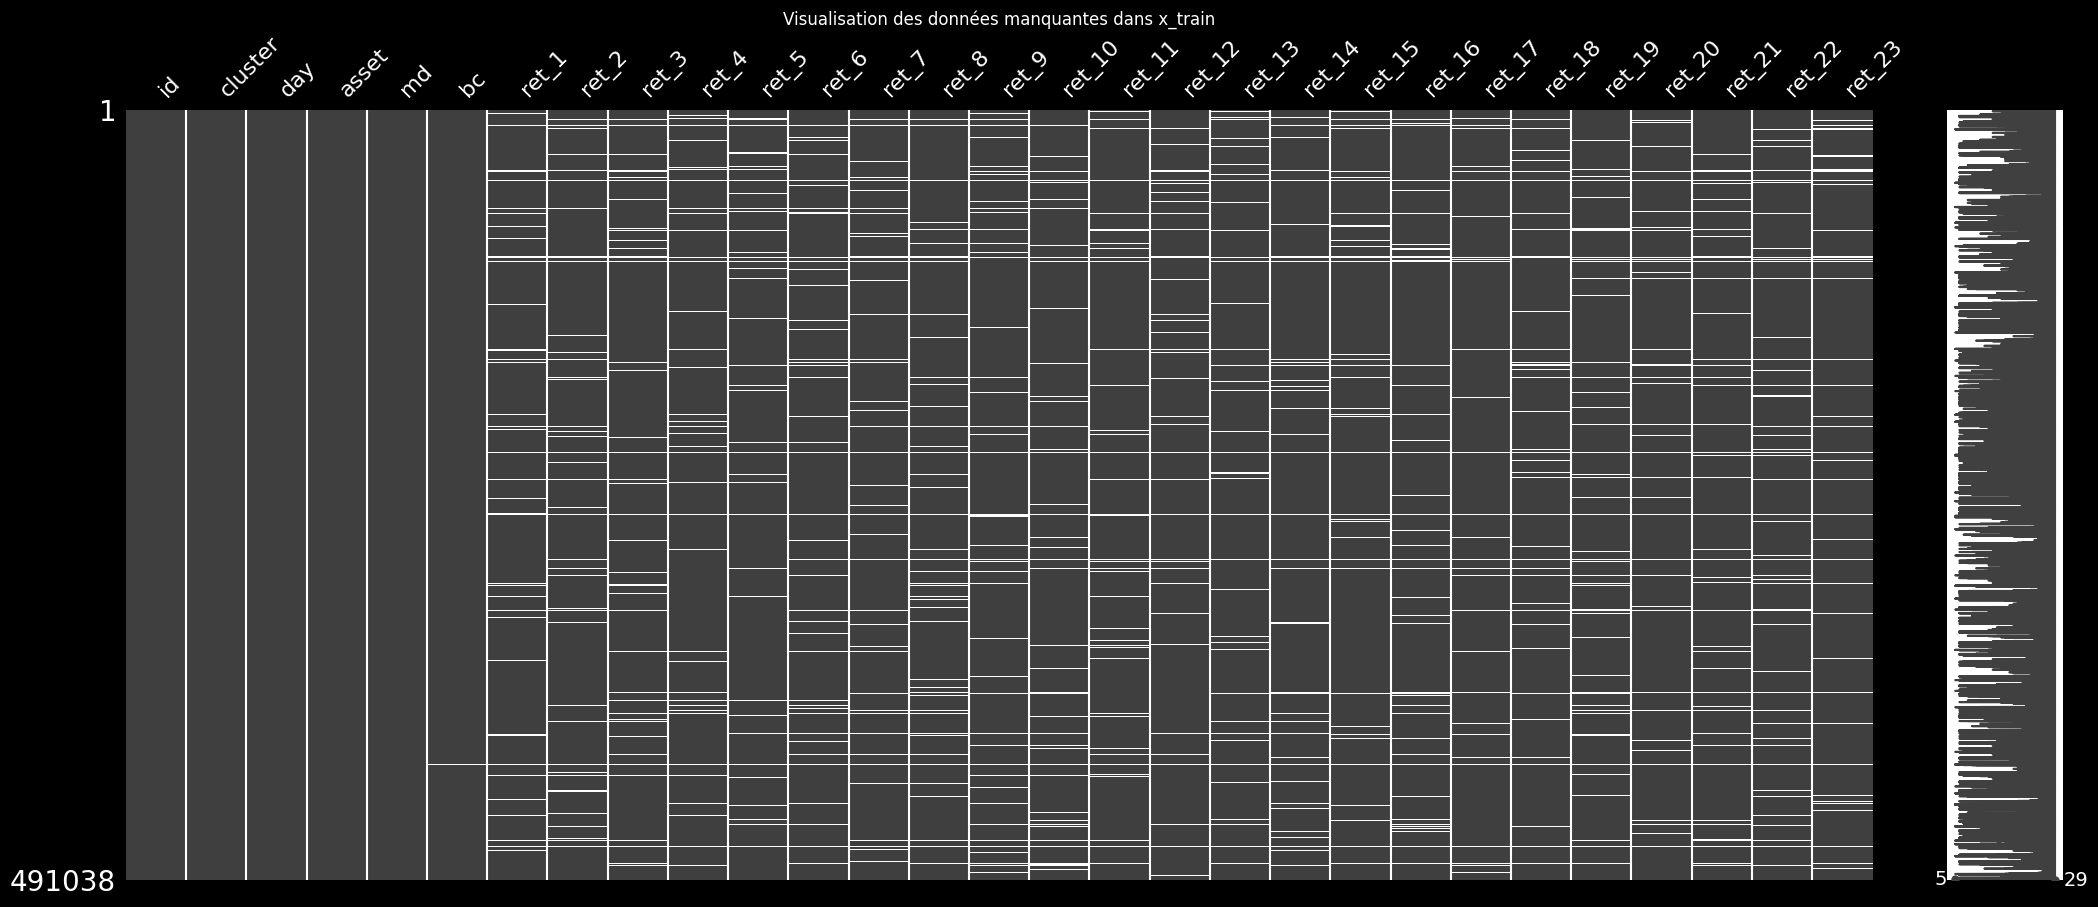

Résumé des données manquantes dans x_train :
         count
ret_20   28373
ret_19   28310
ret_4    28007
ret_21   27984
ret_22   27890
ret_6    27556
ret_7    26963
ret_18   26867
ret_5    26834
ret_23   26706
ret_10   26644
ret_3    26422
ret_11   25931
ret_8    25770
ret_2    25652
ret_12   25367
ret_9    25311
ret_13   24933
ret_14   24812
ret_16   24348
ret_15   24019
ret_17   23977
ret_1    23869
bc        1092
cluster      0
md           0
asset        0
day          0
id           0


In [9]:
msno.matrix(x_train)
plt.title("Visualisation des données manquantes dans x_train")
plt.show()

print("Résumé des données manquantes dans x_train :")
missing_summary = x_train.isnull().sum().to_frame(name='count')
print(missing_summary.sort_values(by='count', ascending=False))

**Analyse des valeurs manquantes**

* Les valeurs manquantes de la feature confidentielle **bc** sont relativement peu nombreuses et ainsi facilement traitables, nous allons remplacer les valeurs manquantes par **la médiane des valeurs du même cluster et du même jour**, afin de garder des données cohérentes **sans créer de biais.**

* Les valeurs manquantes des autres features de rendement **ret_1 à ret_23** sont beaucoup plus nombreuses. Pour ne pas perdre d’information et préserver la structure des clusters, elles seront imputées par **la médiane des rendements des autres actifs du même cluster et du même jour.** Cette méthode permet de ne pas introduire de biais dans les données.

#### 2.3.2 Traitement des valeurs manquantes dans x_train

**Technique :**

* On commence par calculer, dans x_train, les médianes pour chaque groupe défini par cluster et day.

* Ensuite, on effectue un merge entre x_train et ces statistiques afin d’ajouter temporairement une colonne contenant la valeur médiane correspondant à chaque ligne du même groupe.

* Cette colonne sert à remplir (fillna) les valeurs manquantes directement dans x_train.

* Une fois les valeurs manquantes remplacées, la colonne ajoutée est supprimée pour retrouver la structure initiale du jeu de données.


In [10]:
# bc
bc_global_median = x_train['bc'].median()
bc_cluster_day_median = x_train.groupby(['cluster', 'day'])['bc'].median().reset_index()

# merge pour ajouter la médiane locale à x_train
x_train = x_train.merge(bc_cluster_day_median, on=['cluster', 'day'], how='left', suffixes=('', '_median'))
x_train['bc'] = x_train['bc'].fillna(x_train['bc_median'])
x_train['bc'] = x_train['bc'].fillna(bc_global_median)
x_train = x_train.drop(columns='bc_median')

# ret_1 à ret_23
ret_cols = [f'ret_{i}' for i in range(1, 24)]
ret_cluster_day_median = x_train.groupby(['cluster', 'day'])[ret_cols].median().reset_index()

# merge pour ajouter les médianes locales à x_train
x_train = x_train.merge(ret_cluster_day_median, on=['cluster', 'day'], how='left', suffixes=('', '_median'))

for col in ret_cols:
    x_train[col] = x_train[col].fillna(x_train[f'{col}_median'])
    x_train[col] = x_train[col].fillna(x_train[col].median())
    x_train = x_train.drop(columns=[f'{col}_median'])

print("--- NA pour x_train après traitement ---")
print(x_train.isnull().sum())

--- NA pour x_train après traitement ---
id         0
cluster    0
day        0
asset      0
md         0
bc         0
ret_1      0
ret_2      0
ret_3      0
ret_4      0
ret_5      0
ret_6      0
ret_7      0
ret_8      0
ret_9      0
ret_10     0
ret_11     0
ret_12     0
ret_13     0
ret_14     0
ret_15     0
ret_16     0
ret_17     0
ret_18     0
ret_19     0
ret_20     0
ret_21     0
ret_22     0
ret_23     0
dtype: int64


#### 2.3.3 Traitement des valeurs manquantes dans x_test

Pour garantir que le modèle fonctionne correctement sur les données de test, il est important de **ne pas recalculer les statistiques (ici médiane) à partir de x_test**, mais d’utiliser uniquement les statistiques calculées sur **x_train.**  

Cette précaution permet d’éviter le **data leakage**, c’est-à-dire la fuite d’informations provenant du futur ou de l’échantillon de test vers l’entraînement. Si on utilisait x_test pour remplir ses propres valeurs manquantes, le modèle pourrait bénéficier de données qu’il n’aurait pas connues dans un scénario réel de prédiction, ce qui biaiserait les résultats.

In [11]:
# bc
bc_global_median = x_train['bc'].median()
bc_cluster_day_median = x_train.groupby(['cluster', 'day'])['bc'].median().reset_index()

# merge pour ajouter la médiane locale à x_test
x_test = x_test.merge(bc_cluster_day_median, on=['cluster', 'day'], how='left', suffixes=('', '_median'))
x_test['bc'] = x_test['bc'].fillna(x_test['bc_median'])
x_test['bc'] = x_test['bc'].fillna(bc_global_median)
x_test = x_test.drop(columns='bc_median')

# ret_1 à ret_23
ret_cols = [f'ret_{i}' for i in range(1, 24)]
ret_cluster_day_median = x_train.groupby(['cluster', 'day'])[ret_cols].median().reset_index()

# merge pour ajouter les médianes locales à x_test
x_test = x_test.merge(ret_cluster_day_median, on=['cluster', 'day'], how='left', suffixes=('', '_median'))

for col in ret_cols:
    x_test[col] = x_test[col].fillna(x_test[f'{col}_median'])
    x_test[col] = x_test[col].fillna(x_train[col].median())  # fallback global
    x_test = x_test.drop(columns=[f'{col}_median'])

print("--- NA pour x_test après traitement ---")
print(x_test.isnull().sum())

--- NA pour x_test après traitement ---
id         0
cluster    0
day        0
asset      0
md         0
bc         0
ret_1      0
ret_2      0
ret_3      0
ret_4      0
ret_5      0
ret_6      0
ret_7      0
ret_8      0
ret_9      0
ret_10     0
ret_11     0
ret_12     0
ret_13     0
ret_14     0
ret_15     0
ret_16     0
ret_17     0
ret_18     0
ret_19     0
ret_20     0
ret_21     0
ret_22     0
ret_23     0
dtype: int64


### 2.4 Statistiques de dispersion

Nombre de clusters dans l'ensemble d'entraînement : 1464


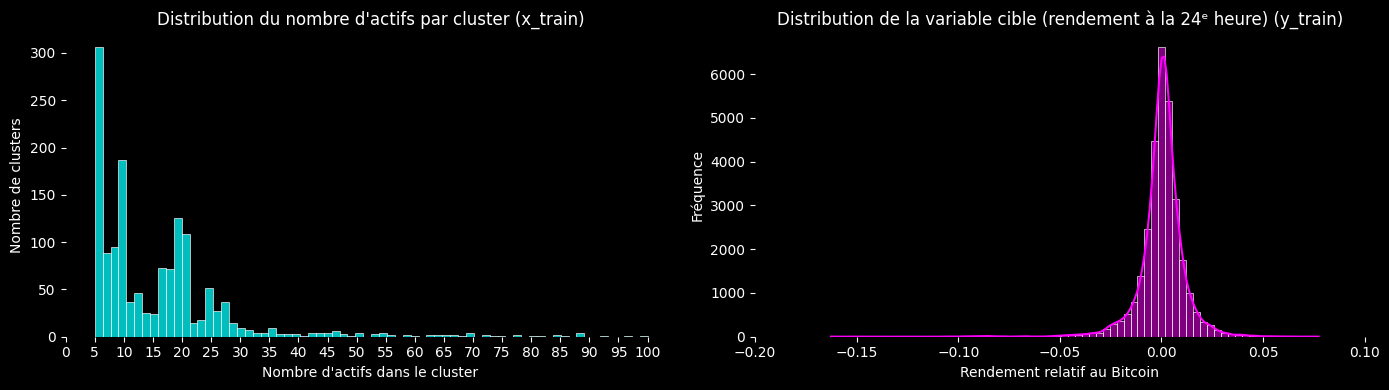

In [13]:
n_clusters = x_train['cluster'].nunique()
print(f"Nombre de clusters dans l'ensemble d'entraînement : {n_clusters}")

assets_per_cluster = x_train.groupby('cluster')['asset'].nunique()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))  # 1 ligne, 2 colonnes

sns.histplot(assets_per_cluster, bins=70, ax=axes[0], color="#00FFFF")
axes[0].set_title("Distribution du nombre d'actifs par cluster (x_train)")
axes[0].set_xlabel("Nombre d'actifs dans le cluster")
axes[0].set_ylabel("Nombre de clusters")
axes[0].set_xticks(range(0, assets_per_cluster.max()+1, 5))
for spine in axes[0].spines.values():
    spine.set_visible(False)

sns.histplot(y_train['target'], bins=70, kde=True, ax=axes[1], color="#FF00FF")
axes[1].set_title("Distribution de la variable cible (rendement à la 24ᵉ heure) (y_train)")
axes[1].set_xlabel("Rendement relatif au Bitcoin")
axes[1].set_ylabel("Fréquence")
axes[1].set_xticks(np.arange(-0.2, 0.15, 0.05))
for spine in axes[1].spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()


### 2.5 Transformation de x_train et x_test

Nous créons la colonne sample_id pour que les formats de nos datasets (x_train, y_train, x_test) correspondent.

* La formule utilisée :`sample_id` = `cluster` × 21 + `day`

L’agrégation consiste ici à regrouper tous les actifs d’un même cluster et d’un même jour (sous un identifiant unique **sample_id**), puis à calculer la **moyenne de chaquen rendement horaires** (ret_1 à ret_23) pour obtenir une seule ligne représentative par **cluster × jour**.

Ex :

| cluster | day | asset | ret_1 | ret_2 | ret_3 | ... |
| ----- | ----- | ----- | ----- | ----- | ----- | ------|
| 0 | 1 | 1   | 0.01  | 0.02  | 0.03  | ... |
| 0 | 1 | 2   | 0.03  | 0.01  | 0.05  | ... |

devient

| sample_id | ret_1 | ret_2 | ret_3 | ... |
| --- | ----- | ----- | ----- | ------|
 1   | 0.02  | 0.015 | 0.04  | ... |

In [14]:
x_train['sample_id'] = x_train['cluster'] * 21 + x_train['day']
x_test['sample_id'] = x_test['cluster'] * 21 + x_test['day']

ret_cols = [f'ret_{i}' for i in range(1, 24)]
x_agg = x_train.groupby('sample_id')[ret_cols].mean().reset_index()

x_agg_extra = x_train.groupby('sample_id').agg({
    'md': 'mean',
    'bc': 'mean'
}).reset_index()
x_agg = x_agg.merge(x_agg_extra, on='sample_id')

display(x_agg.head(), y_train.head())

,sample_id,ret_1,ret_2,ret_3,ret_4,ret_5,ret_6,ret_7,ret_8,ret_9,...,ret_16,ret_17,ret_18,ret_19,ret_20,ret_21,ret_22,ret_23,md,bc
0,0,-0.003180,0.002013,0.002466,-0.010499,0.001454,-0.004188,-0.006318,-0.017592,0.002375,...,0.005674,-0.005408,0.007012,0.005116,0.003174,0.009894,0.002380,0.006052,-5.70555,0.599596
1,1,0.013303,0.001168,0.001216,-0.013527,0.014365,0.007980,-0.005909,0.003051,0.001064,...,0.013930,0.006199,0.003081,0.005278,-0.021580,-0.011090,0.005877,0.001482,-5.70555,0.599596
2,2,-0.012115,0.023476,0.010832,0.004019,-0.000961,-0.015029,-0.003969,0.007315,0.011054,...,-0.012665,-0.008057,0.009439,0.001003,-0.012666,-0.020219,-0.011961,0.009295,-5.70555,0.599596
3,3,-0.008271,0.007486,-0.002561,-0.001278,0.000680,0.020852,-0.002863,-0.015067,0.004542,...,0.012972,0.006508,0.000596,-0.012990,-0.014617,-0.011488,0.004350,0.018666,-5.70555,0.599596
4,4,0.011887,0.001898,-0.010022,-0.013176,0.003421,0.008488,0.002434,0.000776,0.001630,...,0.004875,-0.004859,0.004123,0.019168,-0.001775,-0.001574,0.000908,0.005098,-5.70555,0.599596


,sample_id,target
0,0,0.000301
1,1,-0.011966
2,2,-0.011395
3,3,0.000664
4,4,0.002852


In [15]:
x_test_agg = x_test.groupby('sample_id')[ret_cols].mean().reset_index()
x_test_agg_extra = x_test.groupby('sample_id').agg({
    'md': 'mean',
    'bc': 'mean'
}).reset_index()
x_test_agg = x_test_agg.merge(x_test_agg_extra, on='sample_id')
display(x_test_agg.head())

,sample_id,ret_1,ret_2,ret_3,ret_4,ret_5,ret_6,ret_7,ret_8,ret_9,...,ret_16,ret_17,ret_18,ret_19,ret_20,ret_21,ret_22,ret_23,md,bc
0,30744,-0.014819,-0.055116,0.073720,-0.044865,0.004535,0.003114,0.008935,-0.006937,-0.005302,...,0.000529,-0.019531,0.013128,0.020977,-0.012821,0.000303,0.007835,0.004177,-5.301842,0.077383
1,30745,-0.004014,0.004928,0.000206,-0.007640,0.002657,0.005287,0.005338,-0.008237,0.000762,...,-0.004021,-0.003116,0.024938,0.003068,0.004200,0.000959,0.001212,0.015634,-5.301842,0.077383
2,30746,-0.001192,0.000645,-0.025774,-0.013645,-0.008372,0.011246,0.011226,0.002523,-0.007148,...,0.014708,-0.005423,0.001858,0.007007,0.007432,-0.008231,0.027419,-0.021612,-5.301842,0.077383
3,30747,0.001858,0.000071,-0.002175,-0.001796,0.011681,-0.006844,0.013708,0.011429,-0.006763,...,0.004898,0.000220,-0.003132,-0.006449,0.004770,0.016721,-0.006435,0.001063,-5.301842,0.077383
4,30748,0.006984,0.016957,-0.031100,-0.003070,0.029321,-0.031589,0.005729,0.003309,0.002782,...,-0.022450,0.006566,-0.000153,-0.006487,-0.004821,0.010395,0.001991,-0.003935,-5.301842,0.077383


### 2.6 Création de nouvelles features

Pour enrichir le dataset sans introduire de bruit, nous avons ajouté deux mesures statistiques calculées à partir des rendements intraday :

- **Volatilité intraday**  
  Il s’agit de l’écart type des rendements du jour par cluster. Cette variable résume l’intensité des mouvements du marché durant la journée. Une volatilité élevée indique un environnement plus incertain ou agité, ce qui peut influencer la variable cible.

- **Amplitude intraday (range)**  
  C’est la différence entre le rendement maximal et minimal du jour pour chaque cluster. Cet indicateur met en évidence la dispersion des rendements et permet d’identifier les journées où les variations de prix sont particulièrement marquées.

Ces deux features sont simples, robustes et directement liées au comportement du marché. Elles ajoutent de l’information pertinente au modèle tout en limitant les risques de sur-ajustement ou de pollution du dataset.

(On oublie pas d'ajouter ces variables également dans le dataset x_test)


In [16]:
# Calcul de la volatilité intraday
x_agg['vol_intra'] = x_agg[ret_cols].std(axis=1)
x_test_agg['vol_intra'] = x_test_agg[ret_cols].std(axis=1)

# Calcul du range intraday
x_agg['range_intra'] = x_agg[ret_cols].max(axis=1) - x_agg[ret_cols].min(axis=1)
x_test_agg['range_intra'] = x_test_agg[ret_cols].max(axis=1)  - x_test_agg[ret_cols].min(axis=1)

display(x_agg[["sample_id","vol_intra","range_intra"]].head())

,sample_id,vol_intra,range_intra
0,0,0.006628,0.027847
1,1,0.010509,0.039558
2,2,0.011237,0.043695
3,3,0.011783,0.036890
4,4,0.008662,0.035884


### 2.7 Corrélation des features 

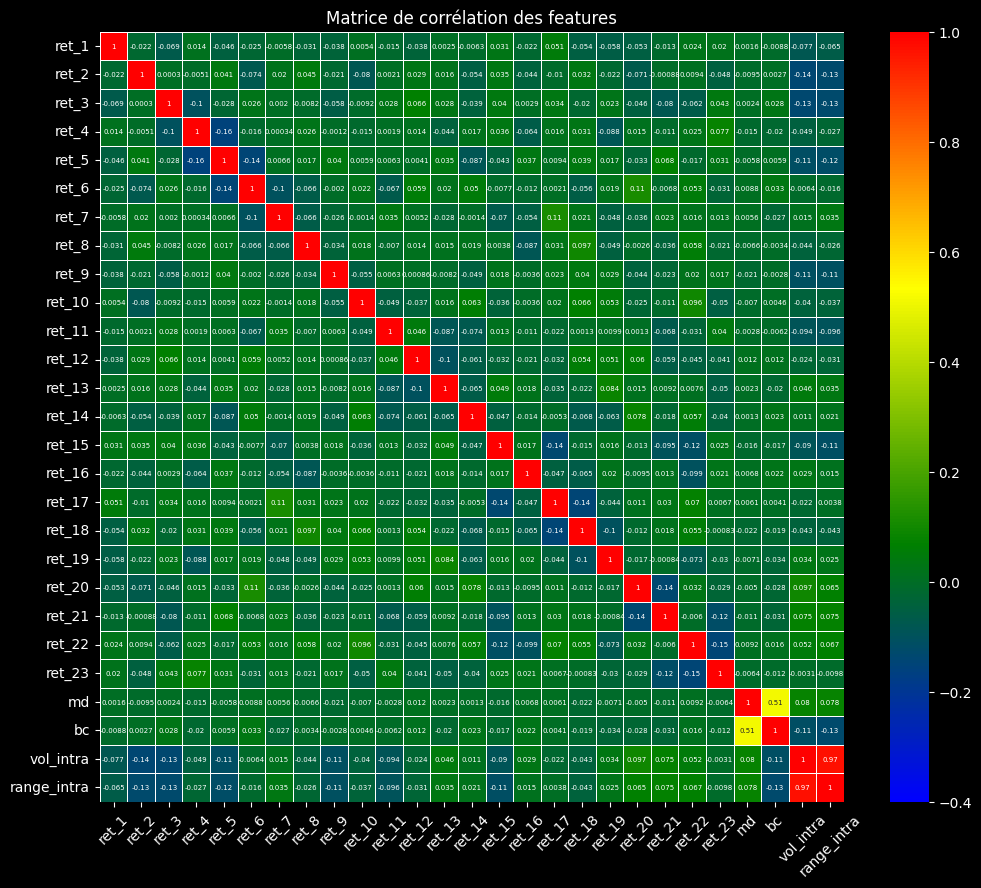

In [17]:
# Matirce de corrélation colormap
colors = ["blue", "green", "yellow", "red"]  # bleu -> vert pour négatif, jaune -> rouge pour positif
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

plt.figure(figsize = (12,10))
plt.title("Matrice de corrélation des features")
sns.heatmap(x_agg[[column for column in x_agg.columns if column != 'sample_id']].corr(), 
            annot = True, 
            annot_kws={"size": 5}, 
            linewidths=.5, 
            cmap=custom_cmap,
            vmin=-0.4, 
            vmax=1)
plt.xticks(rotation=45)
plt.show()

**Analyse de la corrélation des features**

* Les variables inconnues **md** et **bc** présentent une corrélation positive de **0,51**, indiquant qu’elles ont tendance à évoluer ensemble.

* Les valeurs de rendement **ret_t** montrent de **légères corrélations négatives entre heures consécutives**. Cela suggère un **effet de correction intraday** : une hausse à une heure donnée tend à être suivie d’un léger repli l’heure suivante, un comportement classique des cryptomonnaies à haute fréquence.

* La corrélation très forte (**0,97**) entre **vol_intra** et **range_intra** est logique : ces deux mesures capturent la **dispersion intrajournalière**. Quand la volatilité augmente, l’écart entre le maximum et le minimum augmente presque automatiquement.

* Enfin, on observe une petite corrélation négative entre **vol_intra** et **bc** (-0,13), ainsi qu’entre **range_intra** et **bc** (-0,11). Cela signifie que la variable **bc** tend à évoluer légèrement à l’inverse des indicateurs de dispersion.

---

## 3. Modèles

### 3.1 Méhtodologie

Le modèle est entraîné sur **x_train** et **y_train**, qui constituent le **Within-Sample (WS)**, c’est-à-dire les données utilisées pour ajuster les paramètres et apprendre les éventuels patterns. 

On réserve **x_test** comme **Out-Of-Sample (OOS)**, un jeu de données jamais vu par le modèle, pour évaluer sa capacité de généralisation. 

Les performances WS servent à contrôler l’apprentissage et à ajuster les hyperparamètres, tandis que les prédictions OOS permettent de mesurer la robustesse du modèle sur de nouvelles observations, sans risque de **data leakage**.

La métrique RMSE sur les données out of sample n'est donnée qu'un fois la soumission des résultats réalisée sur le site https://challengedata.ens.fr/participants/challenges/71

### 3.2 XGBoost

#### 3.2.1 Modèle 1 avec features initiales 

In [35]:
X = x_agg.drop(['sample_id','vol_intra','range_intra'], axis=1)
Y = y_train['target']

model = xgb.XGBRegressor()
hyperparameter_grid = {
    'n_estimators': [200, 400, 500, 600],
    'max_depth': [3, 4, 6, 10],
    'learning_rate': [0.03, 0.045, 0.05, 0.055],
    'min_child_weight': [1, 3, 5, 10],
    'subsample': [0.5, 0.6, 0.75],
    'colsample_bytree': [0.5, 0.6, 0.75],
    'gamma': [0, 0.1, 0.2],
    'reg_lambda': [0, 0.1, 0.3],
    'alpha': [0, 0.1, 0.3],
    'tree_method': ['hist']
}

cv = TimeSeriesSplit(n_splits=2)

random_cv = RandomizedSearchCV(
    estimator=model,
    param_distributions=hyperparameter_grid, 
    cv=cv, 
    n_iter=100,
    scoring='neg_root_mean_squared_error', 
    n_jobs=1,
    return_train_score=True, 
    verbose=0,
    random_state=42
    )

random_cv.fit(X, Y)

,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'alpha': [0, 0.1, ...], 'colsample_bytree': [0.5, 0.6, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.03, 0.045, ...], ...}"
,n_iter,100
,scoring,'neg_root_mean_squared_error'
,n_jobs,1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


#### 3.2.2 Importance des variables et résultats

----- Résultats du modèle XGBoost avec les features initiales -----
Meilleur score RMSE: 0.00787747
Meilleurs paramètres: {'tree_method': 'hist', 'subsample': 0.75, 'reg_lambda': 0, 'n_estimators': 600, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.5, 'alpha': 0}


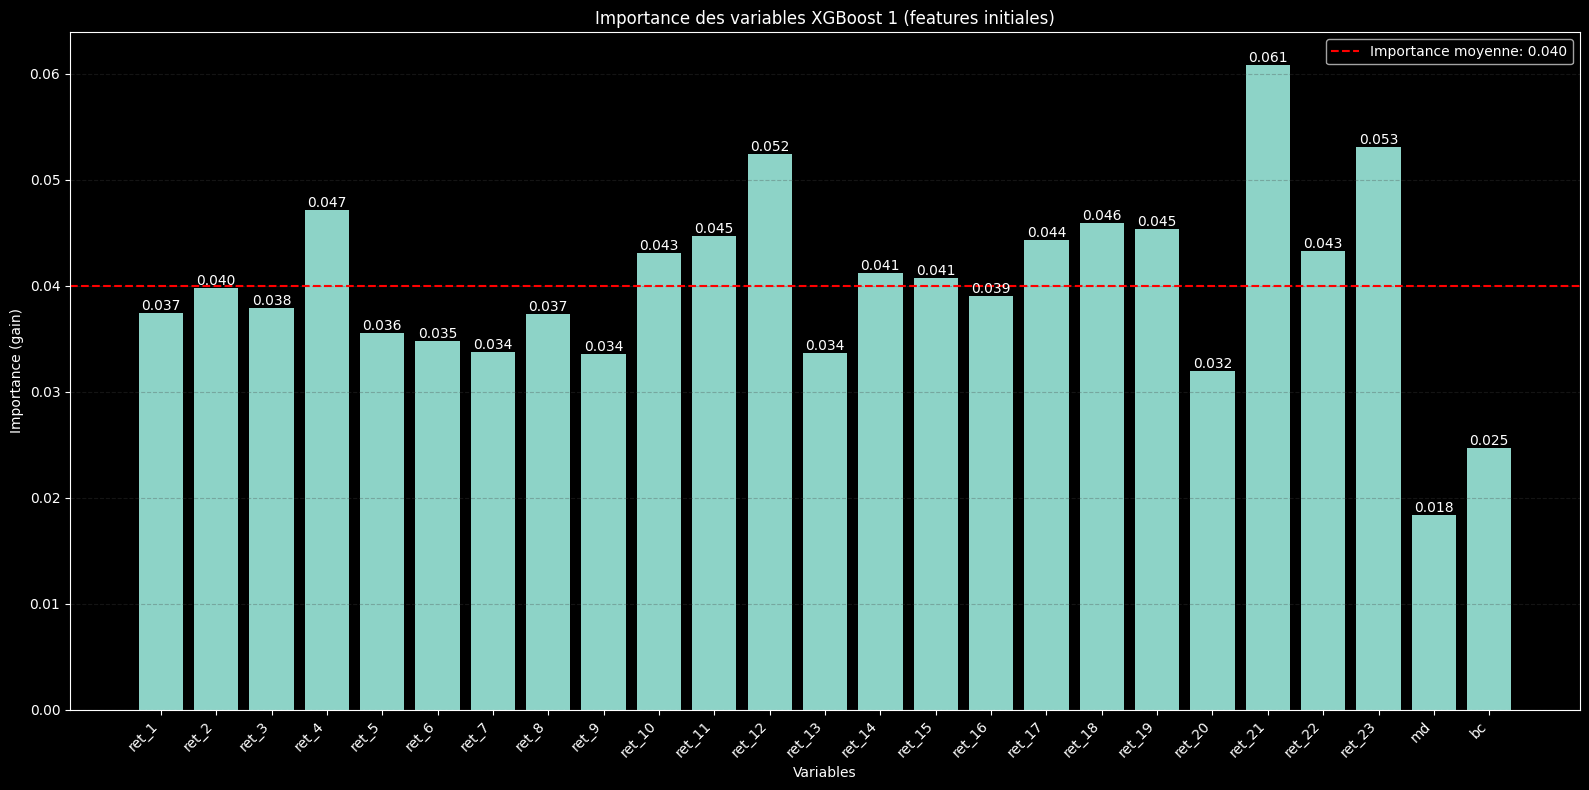

In [36]:
feature_importances = random_cv.best_estimator_.feature_importances_
features = X.columns

plt.figure(figsize=(16, 8))
bars = plt.bar(features, feature_importances)
plt.title('Importance des variables XGBoost 1 (features initiales)')
plt.xlabel('Variables')
plt.ylabel('Importance (gain)')
plt.xticks(rotation=45, ha='right')

mean_importance = np.mean(feature_importances)
plt.axhline(y=mean_importance, color='red', linestyle='--', 
            label=f'Importance moyenne: {mean_importance:.3f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

print("----- Résultats du modèle XGBoost avec les features initiales -----")
print(f"Meilleur score RMSE: {-random_cv.best_score_:.8f}")
print("Meilleurs paramètres:", random_cv.best_params_)

plt.tight_layout()
plt.show()

#### 3.2.3 Modèle 2 avec ajout des nouvelles features

In [37]:
X = x_agg.drop(['sample_id'], axis=1)
Y = y_train['target']

model_2 = xgb.XGBRegressor()
random_cv_2 = RandomizedSearchCV(
    estimator=model_2,
    param_distributions=hyperparameter_grid, 
    cv=cv, 
    n_iter=100,
    scoring='neg_root_mean_squared_error', 
    n_jobs=1,
    return_train_score=True, 
    verbose=0,
    random_state=42
    )

random_cv_2.fit(X, Y)

,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'alpha': [0, 0.1, ...], 'colsample_bytree': [0.5, 0.6, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.03, 0.045, ...], ...}"
,n_iter,100
,scoring,'neg_root_mean_squared_error'
,n_jobs,1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


#### 3.2.4 Importance des variables et résultats

----- Résultats du modèle XGBoost avec ajout des nouvelles features -----
Meilleur score RMSE: 0.00783407
Meilleurs paramètres: {'tree_method': 'hist', 'subsample': 0.75, 'reg_lambda': 0, 'n_estimators': 600, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.5, 'alpha': 0}


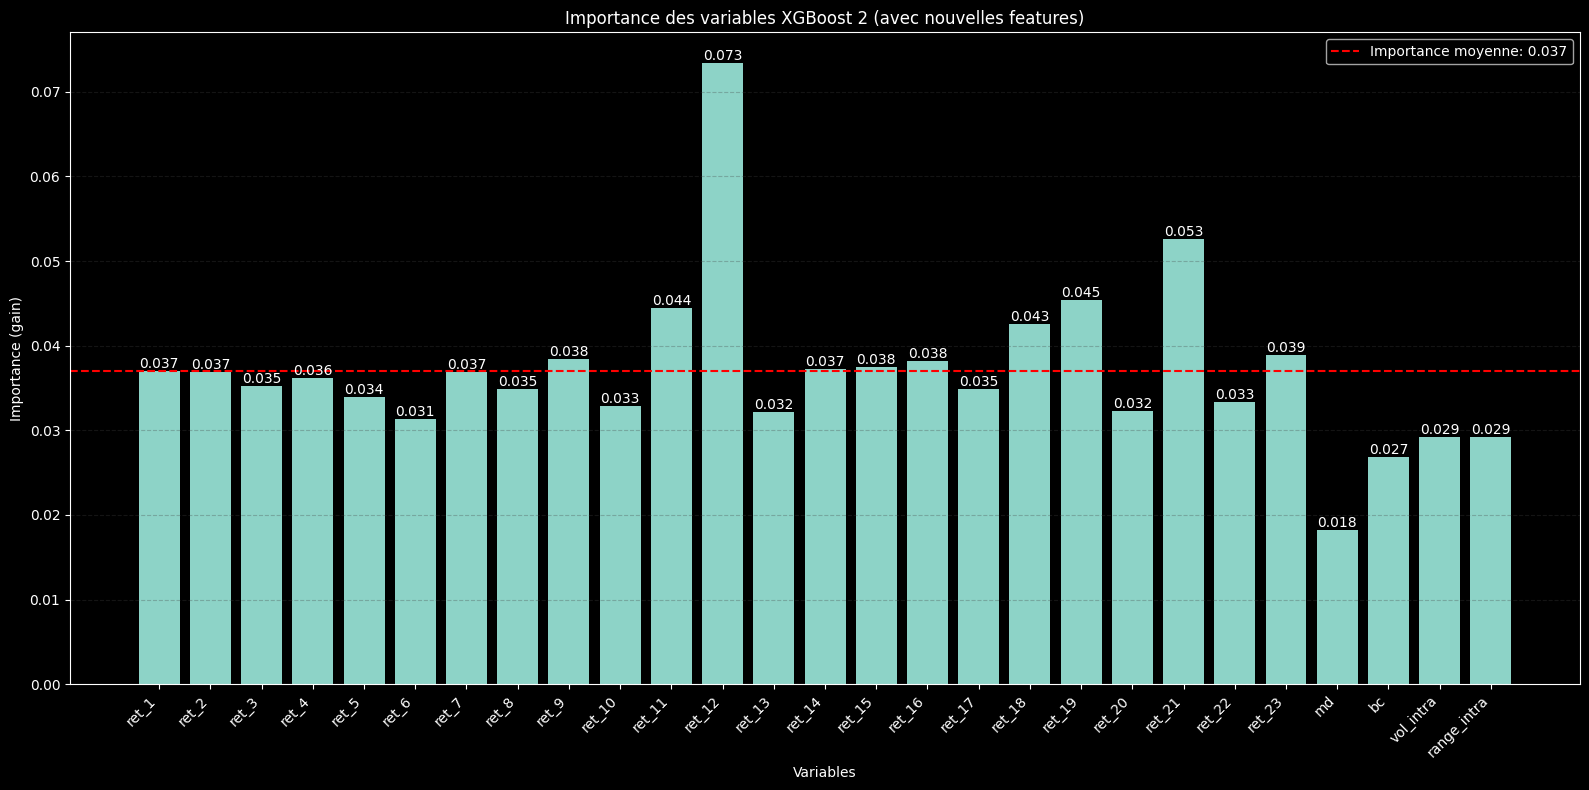

In [38]:
feature_importances_2 = random_cv_2.best_estimator_.feature_importances_
features = X.columns

plt.figure(figsize=(16, 8))
bars = plt.bar(features, feature_importances_2)
plt.title('Importance des variables XGBoost 2 (avec nouvelles features)')
plt.xlabel('Variables')
plt.ylabel('Importance (gain)')
plt.xticks(rotation=45, ha='right')

mean_importance = np.mean(feature_importances_2)
plt.axhline(y=mean_importance, color='red', linestyle='--', 
            label=f'Importance moyenne: {mean_importance:.3f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

print("----- Résultats du modèle XGBoost avec ajout des nouvelles features -----")
print(f"Meilleur score RMSE: {-random_cv_2.best_score_:.8f}")
print("Meilleurs paramètres:", random_cv_2.best_params_)

plt.tight_layout()
plt.show()

**Analyse des résultats des deux modèles XGBoost**

Dans les deux modèles, les variables `md` et `bc` restent les moins influentes, avec une contribution très faible au gain global.  

Pour le deuxième modèle, qui intègre les nouvelles features de dispersion `vol_intra` et `range_intra`, on observe que leur gain est inférieur à la moyenne des autres variables, mais reste supérieur à celui des variables `md` et `bc`.  

En termes de performance, le RMSE passe de **0.00787747** pour le modèle initial à **0.00783407** pour le modèle enrichi. Cette légère amélioration montre que les nouvelles features apportent un signal utile.  

Nous décidons donc de **conserver le modèle 2 avec l’ajout des nouvelles features**, car il améliore légèrement la précision.

#### 3.2.5 Application du modèle sélectionné sur des données OOS

In [18]:
X_test = x_test_agg.drop("sample_id", axis=1)
y_pred = random_cv_2.best_estimator_.predict(X_test)
submission = pd.DataFrame({
    'sample_id': x_test_agg['sample_id'],
    'target': y_pred
})

print("Aperçu du fichier de soumission :")
display(submission.head())

submission.to_csv('output/y_test_XGB1.csv', index=False)

Aperçu du fichier de soumission :


,sample_id,target
0,30744,-0.012510
1,30745,-0.002723
2,30746,-0.001904
3,30747,0.004816
4,30748,0.000500


### 3.3 Random Forest Regressor

#### 3.3.1 Modèle 1 avec features initiales

In [ ]:
X = x_agg.drop(['sample_id','vol_intra','range_intra'], axis=1)
Y = y_train['target']

model_rf = RandomForestRegressor(random_state=42)

param_grid_rf = {
    'n_estimators': [200, 400, 600],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.75],
}

tscv = TimeSeriesSplit(n_splits=2)

random_cv_rf = RandomizedSearchCV(
    estimator=model_rf,
    param_distributions=param_grid_rf,
    n_iter=50,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=0,
    random_state=42,
    return_train_score=True
)

random_cv_rf.fit(X, Y)

In [20]:
print("----- Résultats du modèle Random Forest avec les features initiales -----")
print(f"Meilleur score RMSE: {-random_cv_rf.best_score_:.8f}")
print("Meilleurs paramètres:", random_cv_rf.best_params_)

----- Résultats du modèle Random Forest avec les features initiales -----
Meilleur score RMSE: 0.00996778
Meilleurs paramètres: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.75, 'max_depth': 15}


#### 3.3.2 Modèle 2 avec ajout des nouvelles features

In [ ]:
X = x_agg.drop(['sample_id'], axis=1)
Y = y_train['target']

model_rf_2 = RandomForestRegressor(random_state=42)
tscv_2 = TimeSeriesSplit(n_splits=2)

random_cv_rf_2 = RandomizedSearchCV(
    estimator=model_rf_2,
    param_distributions=param_grid_rf,
    n_iter=50,
    cv=tscv_2,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=0,
    random_state=42,
    return_train_score=True
)

random_cv_rf_2.fit(X, Y)

In [ ]:
print("----- Résultats du modèle Random Forest avec ajout des nouvelles features -----")
print(f"Meilleur score RMSE: {-random_cv_rf_2.best_score_:.8f}")
print("Meilleurs paramètres:", random_cv_rf_2.best_params_)

----- Résultats du modèle Random Forest avec ajout les nouvelles features -----
Meilleur score RMSE: 0.00993112
Meilleurs paramètres: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.75, 'max_depth': 15}


#### 3.3.3 Conclusion Random Forest

Après avoir évalué XGBoost, nous avons testé un Random Forest Regressor afin de comparer les performances des modèles.

Dans un premier temps, avec **uniquement les features initiales**, le modèle Random Forest obtient un **RMSE de 0,00996778.**

Ensuite, nous avons réentraîné le modèle en ajoutant les deux nouvelles variables de dispersion `vol_intra` et `range_intra`. Le score s’améliore légèrement et atteint un **RMSE de 0,00993112**.

Ainsi, comme pour XGBoost, l’ajout de features enrichissant la dynamique intraday permet d’obtenir une petite amélioration, confirmant l’intérêt de ces nouvelles variables malgré un gain limité. **Les performances restent toutefois moins bonnes que celles obtenues avec XGBoost.**

### 3.4 LightGBM

#### 3.4.1 Modèle 1 avec features initiales

In [ ]:
X = x_agg.drop(['sample_id','vol_intra','range_intra'], axis=1)
Y = y_train['target']

model_lgb = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    boosting_type='gbdt',
    random_state=42,
)

param_grid = {
    'num_leaves': [31, 50, 70, 90],
    'max_depth': [-1, 5, 8, 12],
    'learning_rate': [0.03, 0.05, 0.07],
    'n_estimators': [300, 500, 700],
    'min_child_samples': [10, 20, 40],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

cv = TimeSeriesSplit(n_splits=2)

random_lgb = RandomizedSearchCV(
    estimator=model_lgb,
    param_distributions=param_grid,
    n_iter=100,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,
    verbose=-1,
    random_state=42
)

random_lgb.fit(X, Y)

#### 3.4.2 Importance des variables et résultats

----- Résultats du modèle LightGBM avec les features initiales -----
Meilleurs paramètres : {'subsample': 0.7, 'num_leaves': 90, 'n_estimators': 500, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.07, 'colsample_bytree': 1.0}
Meilleur RMSE : 0.0077315517907451045


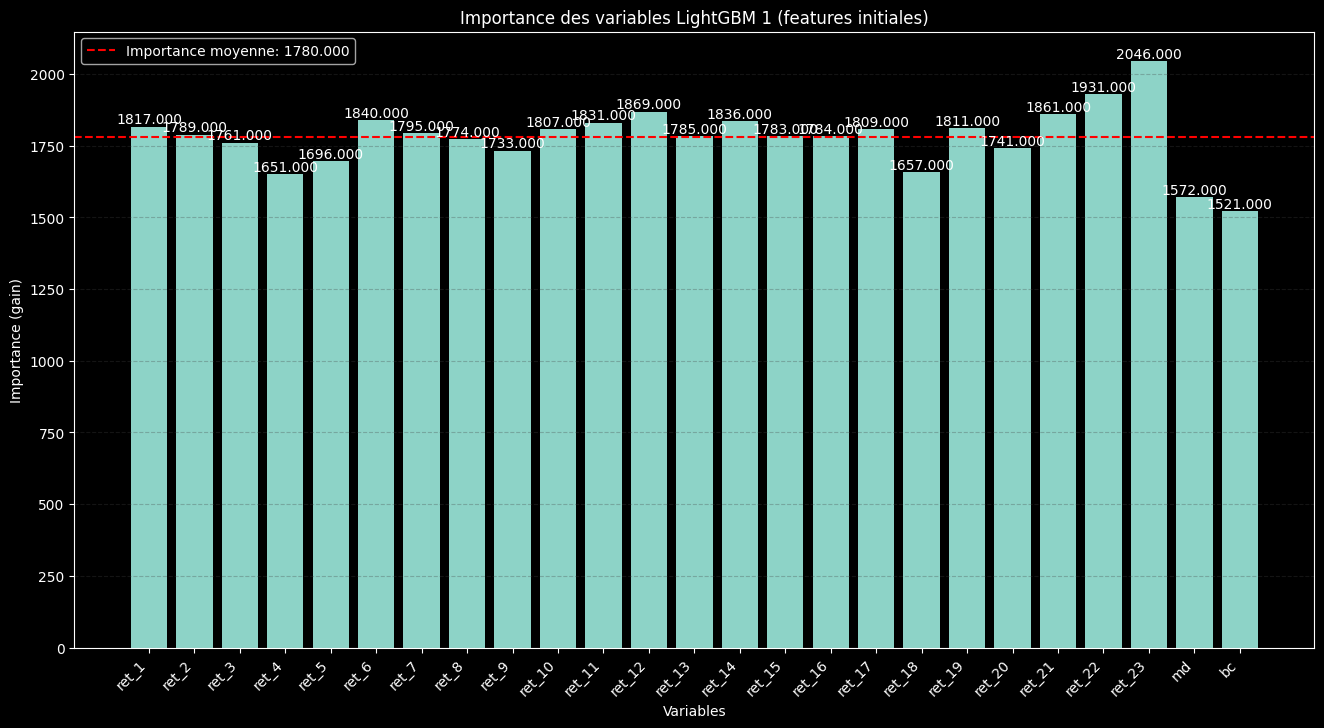

In [29]:
feature_importances_lgb = random_lgb.best_estimator_.feature_importances_
features = X.columns

plt.figure(figsize=(16, 8))
bars = plt.bar(features, feature_importances_lgb)
plt.title('Importance des variables LightGBM 1 (features initiales)')
plt.xlabel('Variables')
plt.ylabel('Importance (gain)')
plt.xticks(rotation=45, ha='right')

mean_importance = np.mean(feature_importances_lgb)
plt.axhline(y=mean_importance, color='red', linestyle='--', 
            label=f'Importance moyenne: {mean_importance:.3f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')
    
print("----- Résultats du modèle LightGBM avec les features initiales -----")
print("Meilleurs paramètres :", random_lgb.best_params_)
print("Meilleur RMSE :", -random_lgb.best_score_)

#### 3.4.3 Modèle 2 avec ajout des nouvelles features

In [ ]:
X = x_agg.drop(['sample_id'], axis=1)
Y = y_train['target']

model_lgb_2 = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    boosting_type='gbdt',
    random_state=42
)

cv_2 = TimeSeriesSplit(n_splits=2)

random_lgb_2 = RandomizedSearchCV(
    estimator=model_lgb_2,
    param_distributions=param_grid,
    n_iter=100,
    cv=cv_2,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,
    verbosity=-1,
    random_state=42
)

random_lgb_2.fit(X, Y)

#### 3.4.4 Importance des variables et résultats

----- Résultats du modèle LightGBM avec ajout des nouvelles features -----
Meilleurs paramètres : {'subsample': 0.7, 'num_leaves': 90, 'n_estimators': 500, 'min_child_samples': 10, 'max_depth': -1, 'learning_rate': 0.07, 'colsample_bytree': 0.9}
Meilleur RMSE : 0.0077225994778054655


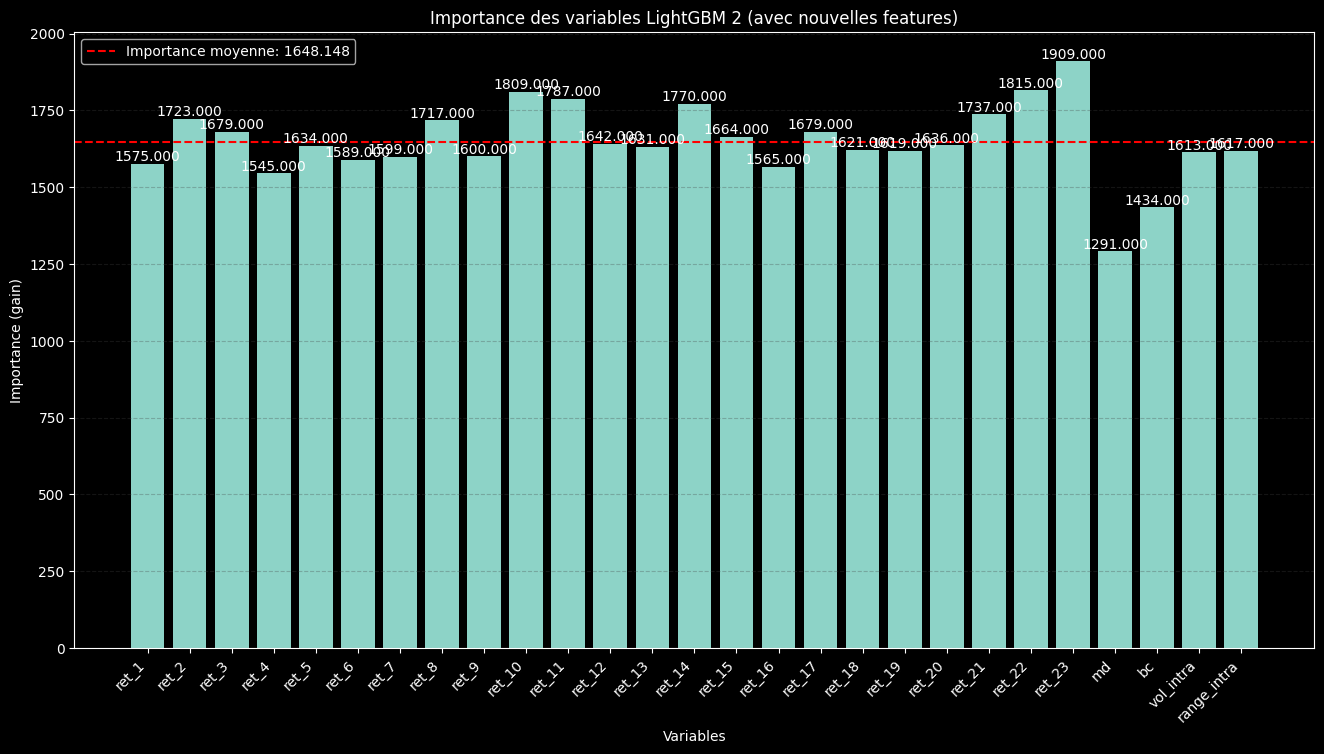

In [42]:
feature_importances_lgb_2 = random_lgb_2.best_estimator_.feature_importances_
features = X.columns

plt.figure(figsize=(16, 8))
bars = plt.bar(features, feature_importances_lgb_2)
plt.title('Importance des variables LightGBM 2 (avec nouvelles features)')
plt.xlabel('Variables')
plt.ylabel('Importance (gain)')
plt.xticks(rotation=45, ha='right')

mean_importance = np.mean(feature_importances_lgb_2)
plt.axhline(y=mean_importance, color='red', linestyle='--', 
            label=f'Importance moyenne: {mean_importance:.3f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')
    
print("----- Résultats du modèle LightGBM avec ajout des nouvelles features -----")
print("Meilleurs paramètres :", random_lgb_2.best_params_)
print("Meilleur RMSE :", -random_lgb_2.best_score_)

#### 3.4.5 Conclusion LightGBM

Après XGBoost et Random Forest Regressor, nous avons poursuivi l'analyse avec le modèle LightGBM afin de comparer ses performances.

**Résultats du modèle LightGBM avec les features initiales :**
L'entraînement du modèle sur le jeu de données original a donné un **RMSE de 0.00773155**.

**Résultats du modèle LightGBM avec l'ajout des nouvelles features :**
L'enrichissement du jeu de données avec de nouvelles variables a permis d'obtenir une légère amélioration des performances, avec une **RMSE de 0.00772259**.

Cette comparaison montre que l'ajout de features pertinentes, même marginalement, contribue à affiner la précision prédictive du modèle LightGBM (très légèrement).

### 3.5 Métamodèle

#### 3.5.1 Stacking Regressor

Le métamodèle combine deux modèles de base pour améliorer la prédiction.

* Modèles de base : **XGBoost et LightGBM**, chacun prédit la cible indépendamment.

* Puis on fait une **LinearRegression** qui prend les prédictions des modèles de base pour produire la prédiction finale.

In [ ]:
X = x_agg.drop(['sample_id'], axis=1)
Y = y_train['target']

xgb_model = xgb.XGBRegressor(
    **random_cv_2.best_params_,       # hyperparamètres optimisés XGBoost,
    verbosity=0,
    random_state=42
)

lgb_model = lgb.LGBMRegressor(
    **random_lgb_2.best_params_,      # hyperparamètres optimisés LightGBM
    verbose=-1,
    random_state=42
)

base_models = [
    ('XGB', xgb_model),
    ('LGB', lgb_model)
]

stacked_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),
    n_jobs=-1,
    passthrough=False 
)

stacked_model.fit(X, Y)

#### 3.5.2 Application du modèle sur des données OOS

In [ ]:
submission_preds = stacked_model.predict(x_test_agg.drop(['sample_id'], axis=1))
submission = pd.DataFrame({
    'sample_id': x_test_agg['sample_id'],
    'target': submission_preds
})

print("Aperçu du fichier de soumission du métamodèle :")
display(submission.head())

submission.to_csv('output/y_test_métamodèle.csv', index=False)

,sample_id,target
0,30744,-0.009951
1,30745,-0.003583
2,30746,0.000186
3,30747,0.000713
4,30748,0.003364


#### 3.5.3 Conclusion Métamodèle

blabla

## 4. Value-Weighted Crypto Cluster

**Expérimentation :**

Jusqu’à présent, nous avons agrégé les données **en moyenne par cluster et par jour**, donnant le même poids à chaque actif.
Cependant, cette approche **équipondérée** n’est pas forcément optimale, car tous les actifs n’ont pas la même influence sur la performance globale du cluster.

Dans cette section, nous allons créer une **agrégation pondérée par la valeur** en surpondérant les actifs dont la **performance moyenne sur l’ensemble de la période** est la plus élevée. Cela permettra de mieux refléter l’impact réel des actifs les plus performants sur le cluster.

### 4.1 Transformation de x_train et x_test

In [24]:
ret_cols = [f'ret_{i}' for i in range(1, 24)]

# x_train
actif_perf = x_train.groupby('asset')[ret_cols].mean().mean(axis=1) 
x_vwc = x_train.merge(actif_perf.rename('perf_moyenne_actif'), on='asset', how='left')

def compute_weights(df):
    df['weight'] = df['perf_moyenne_actif']
    df['weight'] = df['weight'] / df['weight'].sum()  # normalisation pour que somme des poids = 1
    return df

x_vwc = x_vwc.groupby('cluster').apply(compute_weights).reset_index(drop=True)

print("Aperçu du nouveau système de pondération par cluster (x_train et x_test) :")
display(x_vwc[['day','cluster', 'asset', 'perf_moyenne_actif', 'weight']].head())

# x_test
actif_perf_test = x_test.groupby('asset')[ret_cols].mean().mean(axis=1) 
x_vwc_test = x_test.merge(actif_perf_test.rename('perf_moyenne_actif'), on='asset', how='left')

x_vwc_test = x_vwc_test.groupby('cluster').apply(compute_weights).reset_index(drop=True)

display(x_vwc_test[['day','cluster', 'asset', 'perf_moyenne_actif', 'weight']].head())


Aperçu du nouveau système de pondération par cluster (x_train et x_test) :


,day,cluster,asset,perf_moyenne_actif,weight
0,17,0,10,0.000066,0.002020
1,0,0,13,0.000030,0.000920
2,20,0,12,0.000076,0.002323
3,19,0,12,0.000076,0.002323
4,18,0,12,0.000076,0.002323


,day,cluster,asset,perf_moyenne_actif,weight
0,13,1464,7,0.000133,0.003945
1,15,1464,3,0.000105,0.003121
2,14,1464,3,0.000105,0.003121
3,13,1464,3,0.000105,0.003121
4,12,1464,3,0.000105,0.003121


In [25]:
def weighted_returns(df):
    # poids multipliés par ret_1-ret_23
    for col in ret_cols:
        df[col] = df[col] * df['weight']
    # somme par jour pour obtenir le rendement du cluster
    weighted_ret = df.groupby(['cluster','day'])[ret_cols].sum().reset_index()
    return weighted_ret

# train
x_agg_vwc = weighted_returns(x_vwc)

# test
x_agg_vwc_test = weighted_returns(x_vwc_test)

print("Aperçu des données agrégées par cluster et par jour avec la méthode value-weighted (x_train et x_test) :")
display(x_agg_vwc.head(), x_agg_vwc_test.head())

Aperçu des données agrégées par cluster et par jour avec la méthode value-weighted (x_train et x_test) :


,cluster,day,ret_1,ret_2,ret_3,ret_4,ret_5,ret_6,ret_7,ret_8,...,ret_14,ret_15,ret_16,ret_17,ret_18,ret_19,ret_20,ret_21,ret_22,ret_23
0,0,0,-0.000055,0.000126,0.000157,-0.000525,0.000048,-0.000253,-0.000262,-0.000826,...,0.000157,-0.000135,0.000266,-0.000256,0.000321,0.000283,0.000162,0.000468,0.000112,0.000320
1,0,1,0.000713,0.000069,0.000058,-0.000668,0.000688,0.000415,-0.000292,0.000150,...,-0.001214,-0.000256,0.000676,0.000293,0.000155,0.000254,-0.001029,-0.000555,0.000294,0.000069
2,0,2,-0.000686,0.001189,0.000512,0.000219,-0.000026,-0.000722,-0.000212,0.000356,...,-0.000135,-0.000487,-0.000614,-0.000386,0.000449,0.000036,-0.000620,-0.000970,-0.000572,0.000439
3,0,3,-0.000395,0.000377,-0.000133,-0.000074,0.000046,0.000997,-0.000155,-0.000745,...,0.000322,0.000895,0.000632,0.000334,0.000061,-0.000631,-0.000725,-0.000552,0.000200,0.000867
4,0,4,0.000613,0.000086,-0.000464,-0.000621,0.000172,0.000402,0.000160,0.000020,...,0.000810,0.000231,0.000230,-0.000250,0.000231,0.000900,-0.000098,-0.000065,0.000038,0.000243


,cluster,day,ret_1,ret_2,ret_3,ret_4,ret_5,ret_6,ret_7,ret_8,...,ret_14,ret_15,ret_16,ret_17,ret_18,ret_19,ret_20,ret_21,ret_22,ret_23
0,1464,0,-0.000764,-0.002576,0.003609,-0.002178,0.000227,0.000178,0.000287,-0.000240,...,0.000306,0.000082,0.000041,-0.000998,0.000576,0.000956,-0.000592,0.000070,0.000352,0.000235
1,1464,1,-0.000160,0.000294,0.000041,-0.000398,0.000048,0.000244,0.000336,-0.000429,...,-0.000676,-0.001313,-0.000167,-0.000137,0.001241,0.000102,0.000206,0.000005,0.000022,0.000796
2,1464,2,-0.000002,0.000138,-0.001309,-0.000625,-0.000528,0.000634,0.000613,0.000127,...,0.000685,-0.000567,0.000629,-0.000242,0.000108,0.000488,0.000216,-0.000337,0.001282,-0.001089
3,1464,3,0.000004,0.000061,-0.000164,-0.000117,0.000554,-0.000335,0.000667,0.000590,...,0.000084,0.000075,0.000314,-0.000031,-0.000189,-0.000248,0.000224,0.000821,-0.000328,0.000048
4,1464,4,0.000167,0.000708,-0.001477,-0.000099,0.001364,-0.001547,0.000275,0.000036,...,0.000254,0.000249,-0.001023,0.000468,0.000002,-0.000362,-0.000221,0.000572,-0.000009,-0.000256


In [26]:
# --- création de la colonne sample_id dans x_agg_vwc ---

# train
x_agg_vwc['sample_id'] = x_agg_vwc['cluster'] * 21 + x_agg_vwc['day']
x_agg_vwc = x_agg_vwc.drop(['cluster', 'day'], axis=1)

# test
x_agg_vwc_test['sample_id'] = x_agg_vwc_test['cluster'] * 21 + x_agg_vwc_test['day']
x_agg_vwc_test = x_agg_vwc_test.drop(['cluster', 'day'], axis=1)

# --- ajout des colonnes md et bc moyennes par sample_id ---

#train

x_agg_vwc_extra = x_train.groupby('sample_id').agg({
    'md': 'mean',
    'bc': 'mean'
}).reset_index()
x_agg_vwc = x_agg_vwc.merge(x_agg_vwc_extra, on='sample_id')

cols = ['sample_id'] + [c for c in x_agg_vwc.columns if c != 'sample_id']
x_agg_vwc = x_agg_vwc[cols]

#test
x_agg_vwc_extra_test = x_test.groupby('sample_id').agg({
    'md': 'mean',
    'bc': 'mean'
}).reset_index()
x_agg_vwc_test = x_agg_vwc_test.merge(x_agg_vwc_extra_test, on='sample_id')

cols_test = ['sample_id'] + [c for c in x_agg_vwc_test.columns if c != 'sample_id']
x_agg_vwc_test = x_agg_vwc_test[cols_test]

print("aperçu du dataset x_agg_vwc final")
display(x_agg_vwc.head())

aperçu du dataset x_agg_vwc final


,sample_id,ret_1,ret_2,ret_3,ret_4,ret_5,ret_6,ret_7,ret_8,ret_9,...,ret_16,ret_17,ret_18,ret_19,ret_20,ret_21,ret_22,ret_23,md,bc
0,0,-0.000055,0.000126,0.000157,-0.000525,0.000048,-0.000253,-0.000262,-0.000826,0.000119,...,0.000266,-0.000256,0.000321,0.000283,0.000162,0.000468,0.000112,0.000320,-5.70555,0.599596
1,1,0.000713,0.000069,0.000058,-0.000668,0.000688,0.000415,-0.000292,0.000150,0.000096,...,0.000676,0.000293,0.000155,0.000254,-0.001029,-0.000555,0.000294,0.000069,-5.70555,0.599596
2,2,-0.000686,0.001189,0.000512,0.000219,-0.000026,-0.000722,-0.000212,0.000356,0.000524,...,-0.000614,-0.000386,0.000449,0.000036,-0.000620,-0.000970,-0.000572,0.000439,-5.70555,0.599596
3,3,-0.000395,0.000377,-0.000133,-0.000074,0.000046,0.000997,-0.000155,-0.000745,0.000212,...,0.000632,0.000334,0.000061,-0.000631,-0.000725,-0.000552,0.000200,0.000867,-5.70555,0.599596
4,4,0.000613,0.000086,-0.000464,-0.000621,0.000172,0.000402,0.000160,0.000020,0.000040,...,0.000230,-0.000250,0.000231,0.000900,-0.000098,-0.000065,0.000038,0.000243,-5.70555,0.599596


### 4.2 Ajout des nouvelles features

Sur le même principe que dans la prmière méthode ou nous avons fait une aggrégation des données en moyenne des assets pour obtenir le rendement par cluster, nous ajoutons les variables `vol_intra` et `range_intra`dans cette nouvelle méthode avec pondération des actifs selon leur performance. 

Dans la première situation l'ajout de ces variables améliorait légèrement les résultats de nos modèles, c'est pourquoi on décide de les ajouter ici aussi.

In [28]:
# Calcul de vol_intra et de range_intra par cluster et jour
x_agg_vwc['vol_intra'] = x_agg_vwc[ret_cols].std(axis=1)    
x_agg_vwc['range_intra'] = x_agg_vwc[ret_cols].max(axis=1) - x_agg_vwc[ret_cols].min(axis=1) 

x_agg_vwc_test['vol_intra'] = x_agg_vwc_test[ret_cols].std(axis=1)       
x_agg_vwc_test['range_intra'] = x_agg_vwc_test[ret_cols].max(axis=1) - x_agg_vwc_test[ret_cols].min(axis=1) 

## 5. Modèle avec la méthode Value-Weighted

### 5.1 XGBoost

In [54]:
X = x_agg_vwc.drop(['sample_id'], axis=1)
Y = y_train['target']

model_xgb_vwc = xgb.XGBRegressor()
hyperparameter_grid = {
    'n_estimators': [200, 400, 500, 600],
    'max_depth': [3, 4, 6, 10],
    'learning_rate': [0.03, 0.045, 0.05, 0.055],
    'min_child_weight': [1, 3, 5, 10],
    'subsample': [0.5, 0.6, 0.75],
    'colsample_bytree': [0.5, 0.6, 0.75],
    'gamma': [0, 0.1, 0.2],
    'reg_lambda': [0, 0.1, 0.3],
    'alpha': [0, 0.1, 0.3],
    'tree_method': ['hist']
}

cv = TimeSeriesSplit(n_splits=2)

random_cv_xgb_vwc = RandomizedSearchCV(
    estimator=model_xgb_vwc,
    param_distributions=hyperparameter_grid, 
    cv=cv, 
    n_iter=100,
    scoring='neg_root_mean_squared_error', 
    n_jobs=1,
    return_train_score=True, 
    verbose=0,
    random_state=42
    )

random_cv_xgb_vwc.fit(X, Y)

,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'alpha': [0, 0.1, ...], 'colsample_bytree': [0.5, 0.6, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.03, 0.045, ...], ...}"
,n_iter,100
,scoring,'neg_root_mean_squared_error'
,n_jobs,1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


### 5.2 Importance des variables et résultats

----- Résultats du modèle XGBoost avec la méthode value-weighted -----
Meilleurs paramètres : {'tree_method': 'hist', 'subsample': 0.75, 'reg_lambda': 0, 'n_estimators': 600, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.5, 'alpha': 0}
Meilleur RMSE : 0.00801272681800712


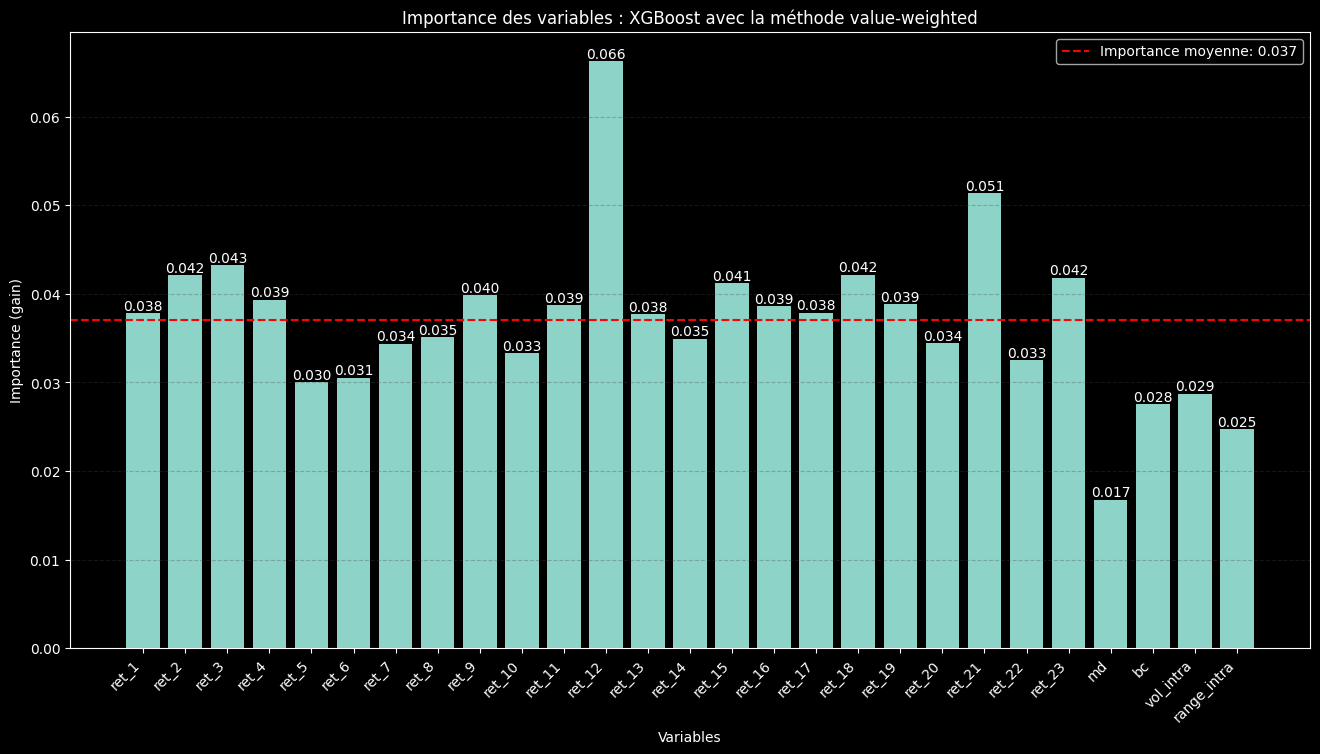

In [56]:
feature_importances_xgb = random_cv_xgb_vwc.best_estimator_.feature_importances_
features = X.columns

plt.figure(figsize=(16, 8))
bars = plt.bar(features, feature_importances_xgb)
plt.title('Importance des variables : XGBoost avec la méthode value-weighted')
plt.xlabel('Variables')
plt.ylabel('Importance (gain)')
plt.xticks(rotation=45, ha='right')

mean_importance = np.mean(feature_importances_xgb)
plt.axhline(y=mean_importance, color='red', linestyle='--', 
            label=f'Importance moyenne: {mean_importance:.3f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')
    
print("----- Résultats du modèle XGBoost avec la méthode value-weighted -----")
print("Meilleurs paramètres :", random_cv_xgb_vwc.best_params_)
print("Meilleur RMSE :", -random_cv_xgb_vwc.best_score_)

### 5.3 Application du modèle sur des données OOS

In [58]:
submission_preds = random_cv_xgb_vwc.best_estimator_.predict(x_test_agg.drop(['sample_id'], axis=1))
submission = pd.DataFrame({
    'sample_id': x_test_agg['sample_id'],
    'target': submission_preds
})

submission.to_csv('output/y_test_XGboost_value_weighted_clusters.csv', index=False)

### 5.4 Conclusion sur la méthode Value Weighted

Après implémentation complète de la pondération des rendements intraday selon la performance moyenne des actifs de chaque cluster, la méthode a été testée sur la plateforme du challenge.

> Le RMSE obtenu est de **0,02214989**, soit une performance nettement inférieure à celles obtenues avec les modèles construits sur les données non pondérées.

Ce résultat suggère que la démarche de surpondérer les actifs « les plus performants » n’est pas adaptée au cadre du problème.